# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [4]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [5]:
# 解压数据
!unzip -q data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


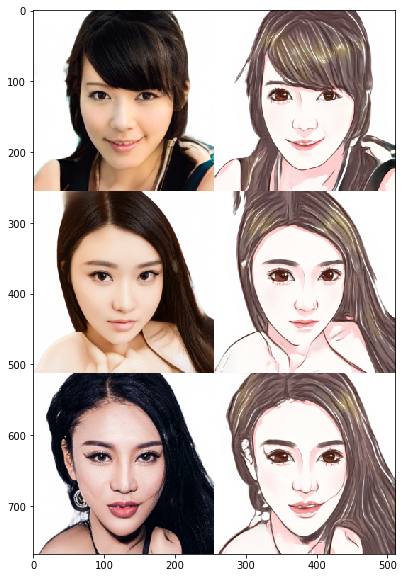

In [6]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [7]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])                                        # 读取一组数据
        img_A2B =  img_A2B/127.5-1                                       # 从0~255归一化至-1~1
        img_A2B = img_A2B.transpose(2,0,1)                                         # 维度变换HWC -> CHW
        img_A = img_A2B[:,:,:256].astype('float32')                                           # 真人照
        img_B = img_A2B[:,:,256:].astype(np.float32)                                          # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [8]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [9]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
             nn.LeakyReLU(0.2),                   # LeakyReLU, leaky=0.2
             nn.Conv2D(in_channels = in_dim, out_channels = out_dim, kernel_size = kernel_size, stride = stride, padding = padding, bias_attr = False ),                   # Conv2D
             nn.BatchNorm2D(out_dim)                    # BatchNorm2D
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
             nn.ReLU(),                   # ReLU
             nn.Conv2DTranspose(in_channels = in_dim, out_channels = out_dim, kernel_size = kernel_size, stride = stride, padding = padding, bias_attr = False ),                   # Conv2DTranspose
             nn.BatchNorm2D(out_dim)                   # nn.BatchNorm2D
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [10]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
             nn.Conv2D(in_channels = in_dim, out_channels = out_dim, kernel_size = kernel_size, stride = stride, padding = padding ,bias_attr = False ) ,                   # Conv2D
             nn.BatchNorm2D(out_dim),                   # BatchNorm2D
             nn.LeakyReLU(0.2)                   # LeakyReLU, leaky=0.2
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [11]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

In [12]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [16]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 20

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [17]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data
        
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A,fake_B),axis = 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict,dtype = 'float32'))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A,fake_B),1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones(g_fake_predict.shape,dtype = 'float32'))
        g_l1_loss = l1_loss(fake_B,real_B)*100
        g_loss = g_bce_loss + g_l1_loss 
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

  1%|          | 1/170 [00:00<00:30,  5.57it/s]

Epoch [1/20] Loss D: [0.5859563], Loss G: [11.395727]


  1%|          | 1/170 [00:00<00:30,  5.54it/s]

Epoch [2/20] Loss D: [0.5355294], Loss G: [11.285255]


  1%|          | 1/170 [00:00<00:30,  5.63it/s]

Epoch [3/20] Loss D: [0.52824134], Loss G: [10.131184]


  1%|          | 1/170 [00:00<00:30,  5.55it/s]

Epoch [4/20] Loss D: [0.558614], Loss G: [10.14588]


  1%|          | 1/170 [00:00<00:30,  5.54it/s]

Epoch [5/20] Loss D: [0.55948454], Loss G: [10.255362]


  1%|          | 1/170 [00:00<00:30,  5.58it/s]

Epoch [6/20] Loss D: [0.7067075], Loss G: [11.15979]


  1%|          | 1/170 [00:00<00:30,  5.54it/s]

Epoch [7/20] Loss D: [0.5747788], Loss G: [9.518141]


  1%|          | 1/170 [00:00<00:30,  5.55it/s]

Epoch [8/20] Loss D: [0.6368741], Loss G: [9.165481]


  1%|          | 1/170 [00:00<00:30,  5.53it/s]

Epoch [9/20] Loss D: [0.5888133], Loss G: [9.456092]


  1%|          | 2/170 [00:00<00:29,  5.69it/s]100%|██████████| 170/170 [00:28<00:00,  5.96it/s]


Epoch [10/20] Loss D: [0.68205094], Loss G: [9.266361]


  1%|          | 1/170 [00:00<00:30,  5.53it/s]

Epoch [11/20] Loss D: [0.6366829], Loss G: [9.4314995]


  1%|          | 1/170 [00:00<00:30,  5.48it/s]

Epoch [12/20] Loss D: [0.5801599], Loss G: [9.248082]


  1%|          | 1/170 [00:00<00:30,  5.48it/s]

Epoch [13/20] Loss D: [0.6146925], Loss G: [9.177375]


  1%|          | 1/170 [00:00<00:30,  5.52it/s]

Epoch [14/20] Loss D: [0.5389877], Loss G: [8.928673]


  1%|          | 1/170 [00:00<00:30,  5.45it/s]

Epoch [15/20] Loss D: [0.701357], Loss G: [8.609959]


  1%|          | 1/170 [00:00<00:31,  5.45it/s]

Epoch [16/20] Loss D: [0.6386955], Loss G: [8.493697]


  1%|          | 1/170 [00:00<00:31,  5.45it/s]

Epoch [17/20] Loss D: [0.5472828], Loss G: [7.725418]


  1%|          | 1/170 [00:00<00:30,  5.48it/s]

Epoch [18/20] Loss D: [1.0381403], Loss G: [8.507555]


  1%|          | 1/170 [00:00<00:30,  5.45it/s]

Epoch [19/20] Loss D: [0.6168664], Loss G: [7.728483]


100%|██████████| 170/170 [00:28<00:00,  5.95it/s]


Epoch [20/20] Loss D: [0.6206326], Loss G: [7.310436]


## 最后：用你补齐的代码试试卡通化的效果吧！

In [18]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch020.pdparams


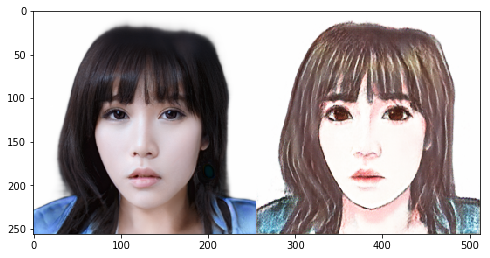

In [20]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
img_name = np.random.choice(test_names)
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人照
img_B = img_A2B[:, 256:]                                  # 卡通图

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()